In [ ]:
#!pip install scikit-learn pandas numpy shap

In [2]:
import shap

import pandas as pd  
import numpy as np  

# Pré-processamento e pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Modelos de ML
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Validação e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# Métricas
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Regressão Random Forest
from sklearn.ensemble import RandomForestRegressor

## Carregando o DataSet e tratando as colunas para melhor uso nos modelos
- **Conversão da coluna `genres` em lista:** Separou os gêneros em uma lista para permitir a análise individual de cada gênero, facilitando a aplicação de técnicas como one-hot encoding.
- **Conversão da data de lançamento:** A coluna `release_date` foi convertida para o formato datetime, permitindo a extração de informações temporais relevantes como ano e mês de lançamento, que podem influenciar o desempenho do filme.
- **Explosão da coluna de gêneros:** Cada filme passou a ocupar uma linha para cada gênero associado, enriquecendo a granularidade dos dados e permitindo que modelos captem relações entre gêneros e receita.
- **Remoção de colunas desnecessárias:** Foram excluídas colunas como `id`, `title`, `status`, `release_date` e `genres` para evitar ruído e focar apenas nas variáveis relevantes para a modelagem.
- **Criação de novas features:** Foram criadas as colunas `release_year` e `release_month`, que podem capturar padrões sazonais ou tendências ao longo do tempo.

Essas transformações tornam o dataset mais adequado para algoritmos de ML, facilitando a codificação de variáveis categóricas, normalização de dados e extração de padrões relevantes para previsão de receita.

In [3]:
# Carregar o dataset
df = pd.read_csv('filmes_filtrados_sem_nulos.csv')

# Converter a coluna 'genres' para uma lista de gêneros
df['genres_names'] = df['genres'].apply(lambda x: x.split('-'))

# Tratando a data
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month

# Explodindo a coluna 'genres_names' para que cada gênero fique em uma linha separada
df = df.explode('genres_names').reset_index(drop=True)

# Retirando colunas desnecessárias para a análise
df = df.drop(columns=['id', 'title', 'status', 'release_date', 'genres'])
df.head()


,original_language,popularity,budget,revenue,runtime,vote_average,vote_count,genres_names,release_year,release_month
0,en,8763.998,129000000.0,352056482.0,116.0,7.079,1365.0,Action,2023,8
1,en,8763.998,129000000.0,352056482.0,116.0,7.079,1365.0,Science Fiction,2023,8
2,en,8763.998,129000000.0,352056482.0,116.0,7.079,1365.0,Horror,2023,8
3,en,5953.227,18000000.0,65675816.0,103.0,7.433,545.0,Horror,2023,4
4,en,5953.227,18000000.0,65675816.0,103.0,7.433,545.0,Mystery,2023,4


In [4]:
# Definindo as colunas de features e o target
features = ['original_language', 'popularity', 'budget', 'runtime', 'vote_average', 'vote_count', 'genres_names','release_year', 'release_month']
features_nominais = ['genres_names', 'original_language']
X = df[features]
y = df['revenue']
# Dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=87)

# Definindo o KFold para o cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=87)

In [5]:
# Pipeline para colunas nominais com StandardScaler
preprocessor_std = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_nominais),
        ('num', StandardScaler(), [col for col in features if col not in features_nominais])
    ]
)

pipeline_std = Pipeline([
    ('preprocess', preprocessor_std),
    ('regressor', KNeighborsRegressor())
])

# Parâmetros para GridSearchCV
param_grid = {
    'regressor__n_neighbors': [3, 5, 7, 9],
    'regressor__weights': ['uniform', 'distance']
}

grid = GridSearchCV(
    pipeline_std,
    param_grid,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Melhores parâmetros:", grid.best_params_)
print("Melhor score (neg MSE):", grid.best_score_)


Melhores parâmetros: {'regressor__n_neighbors': 5, 'regressor__weights': 'distance'}
Melhor score (neg MSE): -7029817677680000.0


In [6]:
# Pipeline para colunas nominais com StandardScaler e SVM + GridSearchCV para o parâmetro C
preprocessor_standard = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_nominais),
        ('num', StandardScaler(), [col for col in features if col not in features_nominais])
    ]
)

pipeline_svm = Pipeline([
    ('preprocess', preprocessor_standard),
    ('regressor', SVR())
])

# Parâmetros para GridSearchCV (analisando o parâmetro C)
param_grid_svm = {
    'regressor__C': [0.1, 1, 10, 100]
}

grid_svm = GridSearchCV(
    pipeline_svm,
    param_grid_svm,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)

print("Melhor parâmetro C:", grid_svm.best_params_)
print("Melhor score (neg MSE):", grid_svm.best_score_)

Melhor parâmetro C: {'regressor__C': 100}
Melhor score (neg MSE): -3.704826748368972e+16


# Usando de Log nas Features "budget" e "revenue": 
O uso da transformação logarítmica nas variáveis "budget" e "revenue" é uma prática comum em problemas de regressão envolvendo valores financeiros, pois esses dados costumam apresentar grande dispersão e distribuição assimétrica (com muitos valores extremos). Ao aplicar o log, reduzimos o impacto de outliers, aproximamos a distribuição dos dados de uma normal e facilitamos o aprendizado dos modelos de machine learning. Isso pode resultar em previsões mais estáveis e métricas de avaliação mais realistas, além de melhorar a capacidade do modelo de capturar relações proporcionais entre as variáveis.

In [7]:
# Criar uma cópia do dataframe
df_log = df.copy()

# Aplicar log1p para lidar com valores zero
df_log['budget'] = np.log1p(df_log['budget'])

# X e y
X_log = df_log[features]
y = df['revenue'] 

# Dividir em treino e teste
X_train_log, X_test_log, y_train, y_test = train_test_split(X_log, y, test_size=0.3, random_state=87)

# Log1p apenas no y_train
y_train_log = np.log1p(y_train)

In [8]:
# Pipeline para colunas nominais com StandardScaler e SVM + GridSearchCV para o parâmetro C, usando dados com log
pipeline_svm_log = Pipeline([
    ('preprocess', preprocessor_standard),
    ('regressor', SVR())
])

param_grid_svm_log = {
    'regressor__C': [0.1, 1, 10, 100]
}

grid_svm_log = GridSearchCV(
    pipeline_svm_log,
    param_grid_svm_log,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_svm_log.fit(X_train_log, y_train_log)

print("Melhor parâmetro C (log):", grid_svm_log.best_params_)
print("Melhor score (neg MSE, log):", grid_svm_log.best_score_)


Melhor parâmetro C (log): {'regressor__C': 10}
Melhor score (neg MSE, log): -1.902796595714765


## Regressão com Random Forest com budget, popularity, runtime, vote_average e vote_count

O modelo de Regressão com Random Forest é um tipo de ensemble learning que combina várias árvores de decisão para melhorar a precisão e reduzir o risco de overfitting. Ele é especialmente útil quando há relações não lineares entre as variáveis e quando temos outliers, como é o caso com valores de budget e revenue. Esse modelo é robusto, simples de ajustar e interpretável em termos de importância de cada variável.

In [ ]:
features = [
    'original_language', 'popularity', 'budget', 'runtime', 
    'vote_average', 'vote_count', 'genres_names', 
    'release_year', 'release_month'
]
features_nominais = ['genres_names', 'original_language']

# com log
X = df[features]
y_log = np.log1p(df['revenue'])

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.3, random_state=87)
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_nominais),
        ('num', StandardScaler(), [col for col in features if col not in features_nominais])
    ]
)
pipeline_rf_log = Pipeline([
    ('preprocess', preprocessor_rf),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=87))
])
pipeline_rf_log.fit(X_train, y_train_log)
y_pred_log = pipeline_rf_log.predict(X_test)
y_pred_log_original = np.expm1(y_pred_log)
y_test_log_original = np.expm1(y_test_log)
mse_log = mean_squared_error(y_test_log_original, y_pred_log_original)
r2_log = r2_score(y_test_log_original, y_pred_log_original)

print("Random Forest (com log)")
print("MSE:", mse_log)
print("R²:", r2_log)

# sem log
y = df['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=87)

pipeline_rf = Pipeline([
    ('preprocess', preprocessor_rf),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Random Forest (sem log)")
print("MSE:", mse)
print("R²:", r2)

Random Forest (com log)
MSE: 1958740565932538.5
R²: 0.9438750912767355
Random Forest (sem log)
MSE: 1305474796009980.0
R²: 0.9625934873454263


## Regressão com KNN

In [10]:
# Pipeline para colunas nominais com StandardScaler e KNN, usando dados com log
pipeline_knn_log = Pipeline([
    ('preprocess', preprocessor_standard),
    ('regressor', KNeighborsRegressor())
])

param_grid_knn_log = {
    'regressor__n_neighbors': [3, 5, 7, 9],
    'regressor__weights': ['uniform', 'distance']
}

grid_knn_log = GridSearchCV(
    pipeline_knn_log,
    param_grid_knn_log,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_knn_log.fit(X_train_log, y_train_log)

print("Melhores parâmetros (KNN log):", grid_knn_log.best_params_)
print("Melhor score (neg MSE, KNN log):", grid_knn_log.best_score_)

Melhores parâmetros (KNN log): {'regressor__n_neighbors': 9, 'regressor__weights': 'distance'}
Melhor score (neg MSE, KNN log): -2.3056250963677756


In [11]:
modelos = {
    'SVM (StandardScaler)': grid_svm,
    'SVM (StandardScaler com log)': grid_svm_log,
    'KNN (StandardScaler)': grid,
    'KNN (StandardScaler com log)': grid_knn_log,
    'Random Forest (StandardScaler)': pipeline_rf,
    'Random Forest (StandardScaler com log)': pipeline_rf_log,
}

resultados = []

for nome, modelo in modelos.items():
    if 'com log' in nome:
        y_pred_log = modelo.predict(X_test_log)
        y_pred = np.expm1(y_pred_log)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
    else:
        y_pred = modelo.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
    resultados.append({'Modelo': nome, 'MSE': mse, 'R²': r2})

resultados_df = pd.DataFrame(resultados)
print(resultados_df)

                                   Modelo           MSE        R²
0                    SVM (StandardScaler)  3.941641e+16 -0.129421
1            SVM (StandardScaler com log)  7.976347e+15  0.771449
2                    KNN (StandardScaler)  7.062214e+15  0.797642
3            KNN (StandardScaler com log)  1.041102e+16  0.701687
4          Random Forest (StandardScaler)  1.305475e+15  0.962593
5  Random Forest (StandardScaler com log)  3.965721e+16 -0.136320


                         Feature  Importance
69                    vote_count    0.469870
66                        budget    0.316761
65                    popularity    0.070783
70                  release_year    0.044964
67                       runtime    0.034038
68                  vote_average    0.032638
71                 release_month    0.015184
64          original_language_zh    0.005762
14  genres_names_Science Fiction    0.000804
7            genres_names_Family    0.000782


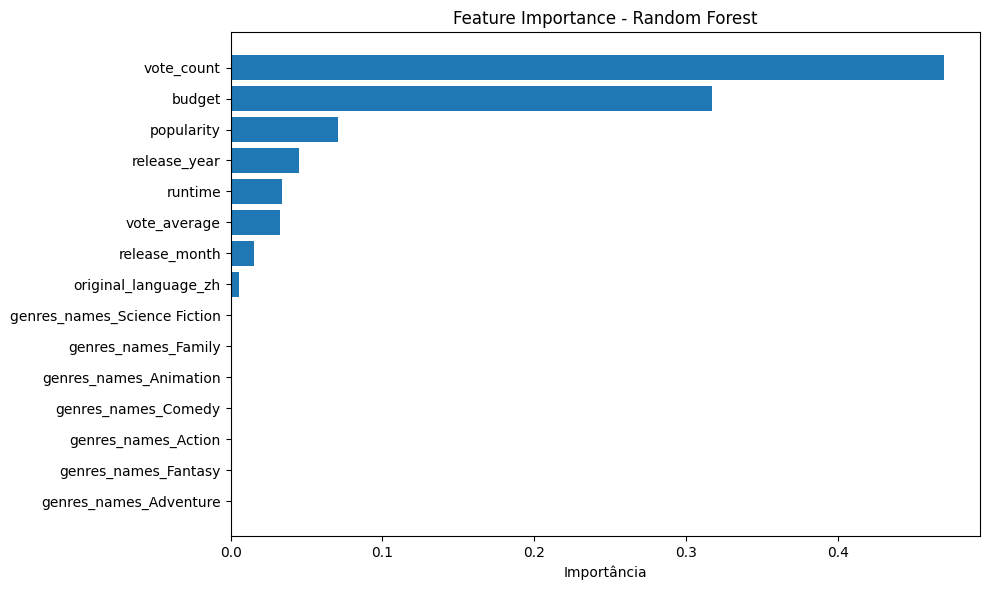

In [12]:
importances = pipeline_rf.named_steps['regressor'].feature_importances_

# Recuperar os nomes das colunas transformadas
onehot_columns = pipeline_rf.named_steps['preprocess'].transformers_[0][1] \
    .get_feature_names_out(features_nominais)
numeric_columns = [col for col in features if col not in features_nominais]
all_feature_names = np.concatenate([onehot_columns, numeric_columns])

# Criar DataFrame ordenado
importances_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Exibir
print(importances_df.head(10))

# Plotar
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(importances_df['Feature'].head(15), importances_df['Importance'].head(15))
plt.gca().invert_yaxis()
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()


                 Feature  Importance Mean  Importance Std
69            vote_count         0.867006        0.018930
66                budget         0.614527        0.010030
65            popularity         0.088583        0.002184
70          release_year         0.087334        0.004105
68          vote_average         0.053081        0.001763
67               runtime         0.050879        0.003213
64  original_language_zh         0.016511        0.000878
71         release_month         0.015859        0.000643
37  original_language_hi         0.000483        0.000075
29  original_language_en         0.000320        0.000029


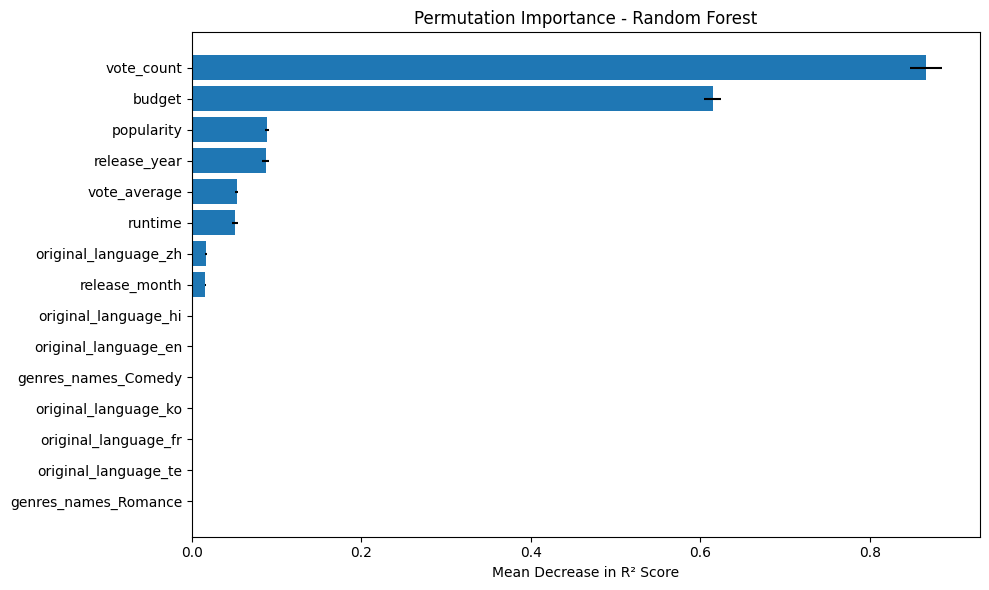

In [13]:
from sklearn.inspection import permutation_importance

# Obter os dados de teste transformados e converter para array denso
X_test_transformed = pipeline_rf.named_steps['preprocess'].transform(X_test).toarray()

# Calcular Permutation Importance
result = permutation_importance(
    pipeline_rf.named_steps['regressor'], 
    X_test_transformed, 
    y_test,
    n_repeats=10,
    random_state=87,
    scoring='r2'
)

# Criar DataFrame com os resultados
perm_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values('Importance Mean', ascending=False)

# Exibir as 10 features mais importantes
print(perm_importance_df.head(10))

# Plotar
plt.figure(figsize=(10,6))
plt.barh(perm_importance_df['Feature'].head(15), 
         perm_importance_df['Importance Mean'].head(15),
         xerr=perm_importance_df['Importance Std'].head(15))
plt.gca().invert_yaxis()
plt.title("Permutation Importance - Random Forest")
plt.xlabel("Mean Decrease in R² Score")
plt.tight_layout()
plt.show()

                 Feature  Importance Mean  Importance Std
69            vote_count         0.858302        0.022510
66                budget         0.613347        0.011067
65            popularity         0.087608        0.001457
70          release_year         0.087459        0.004893
68          vote_average         0.053262        0.002096
67               runtime         0.048749        0.002524
64  original_language_zh         0.016645        0.001021
71         release_month         0.015745        0.000645
37  original_language_hi         0.000465        0.000043
29  original_language_en         0.000300        0.000024


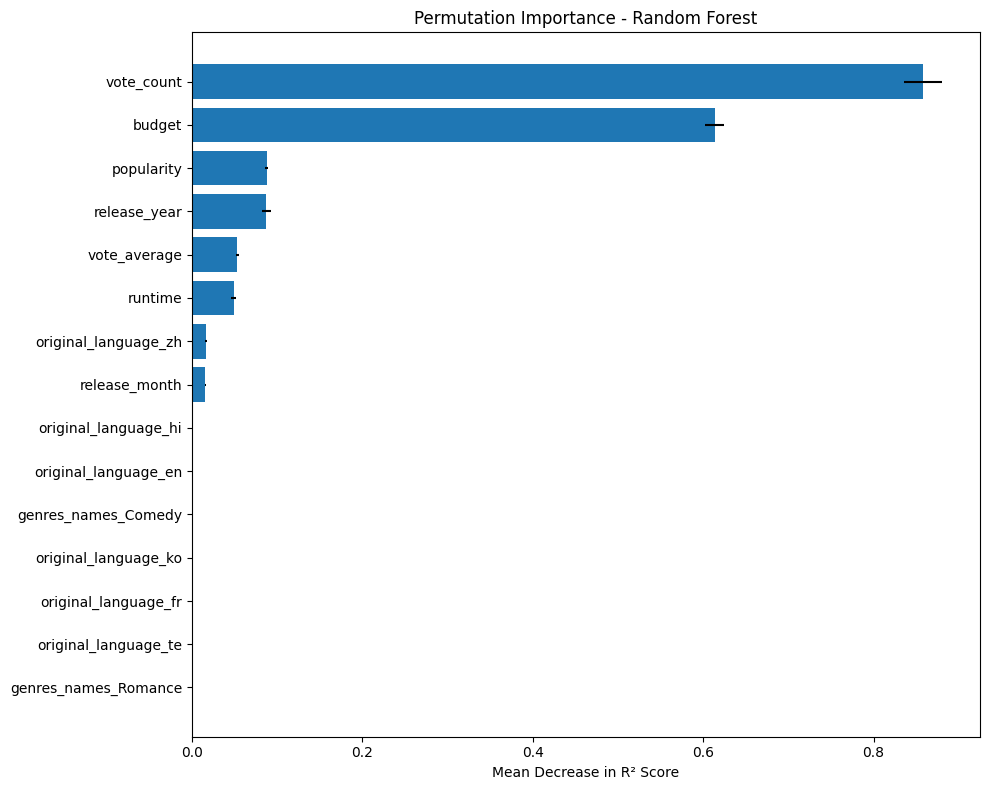

In [14]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# Obter os dados de teste transformados
preprocessor = pipeline_rf.named_steps['preprocess']
X_test_transformed = preprocessor.transform(X_test)

# Converter para array denso se for esparso
if hasattr(X_test_transformed, "toarray"):
    X_test_dense = X_test_transformed.toarray()
else:
    X_test_dense = X_test_transformed

# Calcular Permutation Importance
rf_model = pipeline_rf.named_steps['regressor']
result = permutation_importance(
    rf_model, 
    X_test_dense, 
    y_test,
    n_repeats=5,  # Reduzir para melhor performance
    random_state=87,
    scoring='r2',
    n_jobs=-1  # Usar todos os núcleos
)

# Recuperar nomes das features
numeric_features = [f for f in features if f not in features_nominais]
categorical_features = preprocessor.transformers_[0][1].get_feature_names_out(features_nominais)
all_feature_names = list(categorical_features) + numeric_features

# Criar DataFrame com os resultados
perm_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values('Importance Mean', ascending=False)

# Exibir as 10 features mais importantes
print(perm_importance_df.head(10))

# Plotar
plt.figure(figsize=(10, 8))
plt.barh(perm_importance_df['Feature'].head(15), 
         perm_importance_df['Importance Mean'].head(15),
         xerr=perm_importance_df['Importance Std'].head(15))
plt.gca().invert_yaxis()
plt.title("Permutation Importance - Random Forest")
plt.xlabel("Mean Decrease in R² Score")
plt.tight_layout()
plt.show()

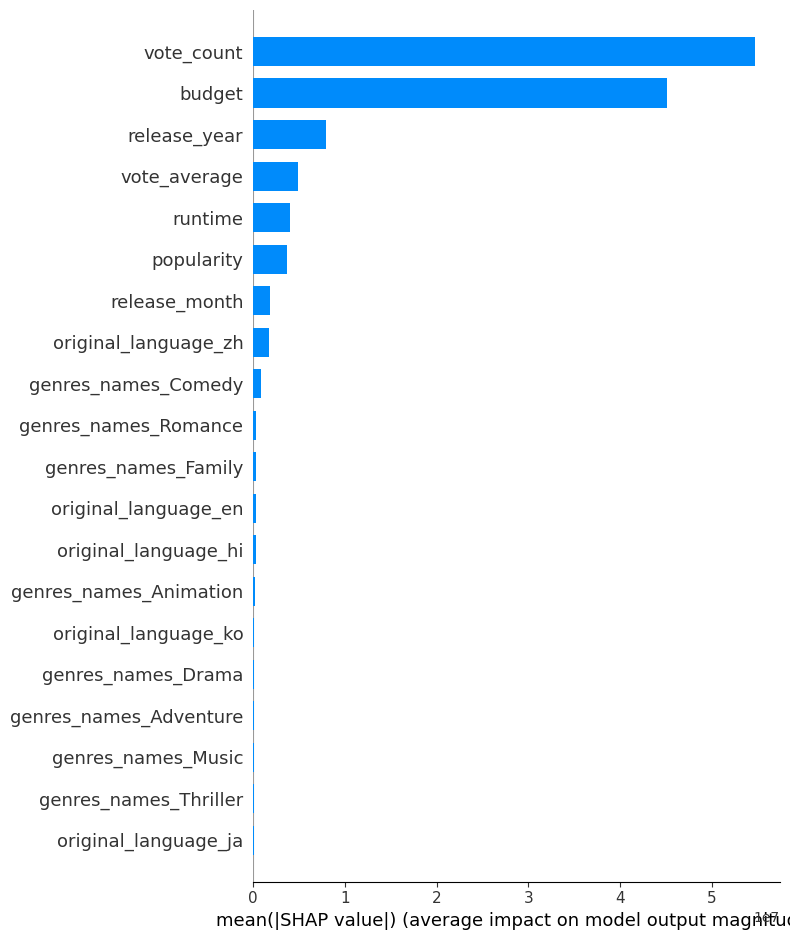

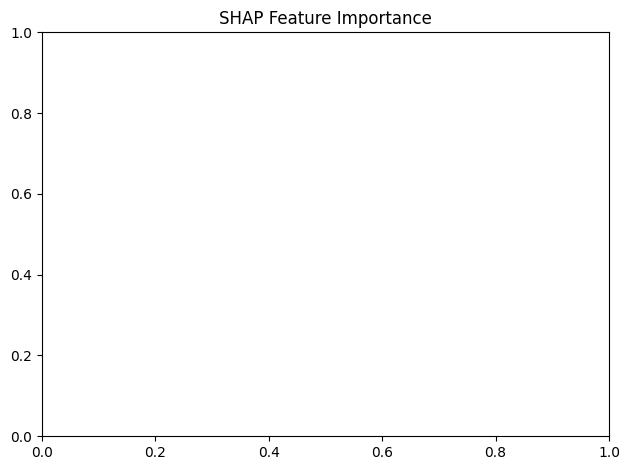

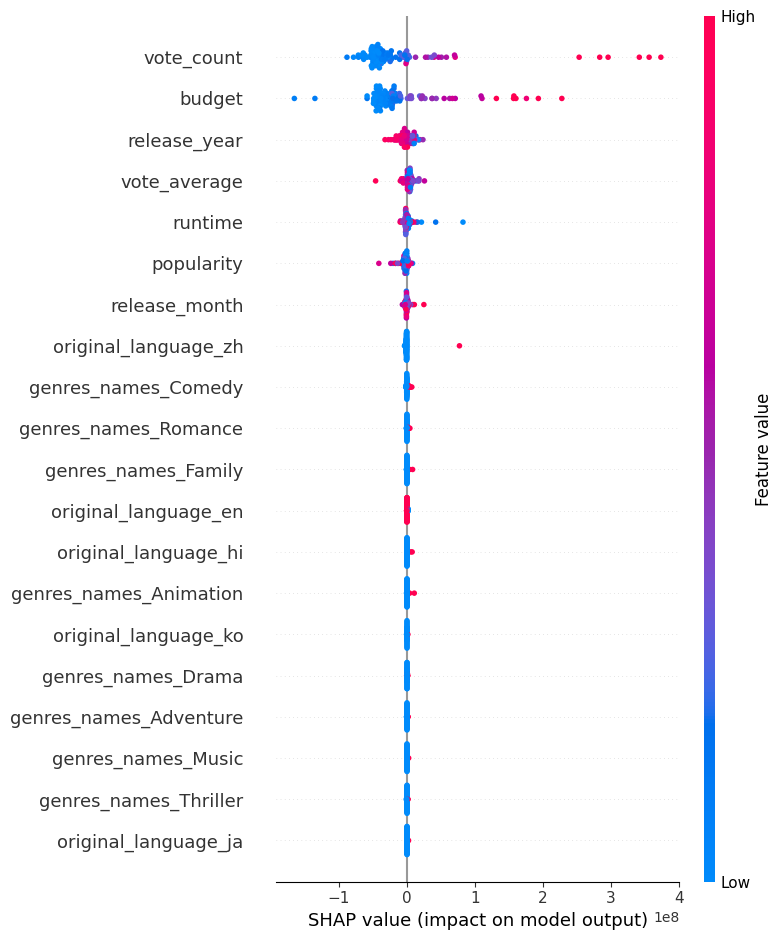

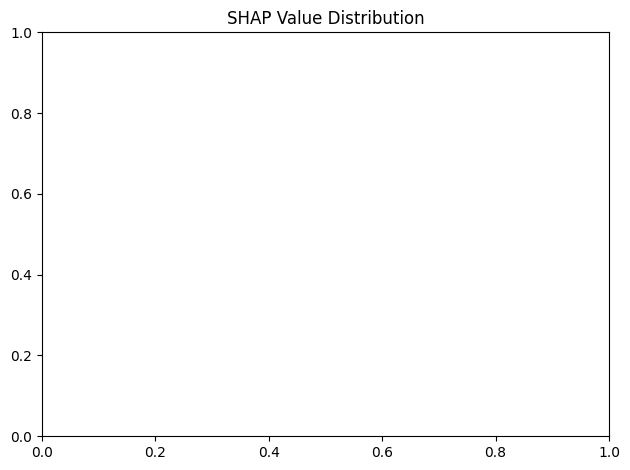

<Figure size 1000x600 with 0 Axes>

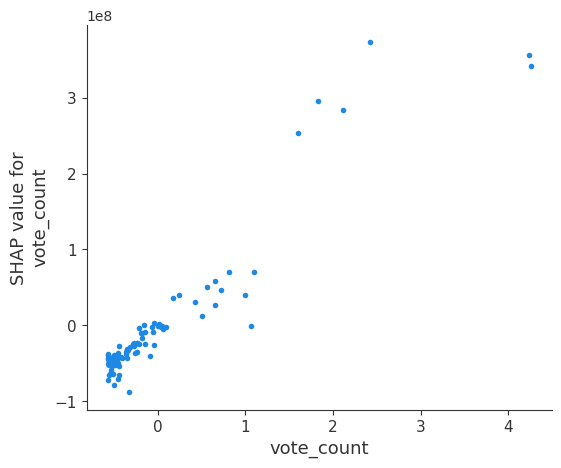

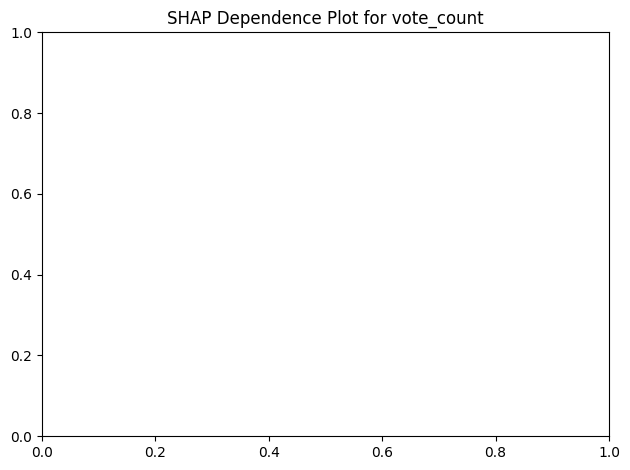

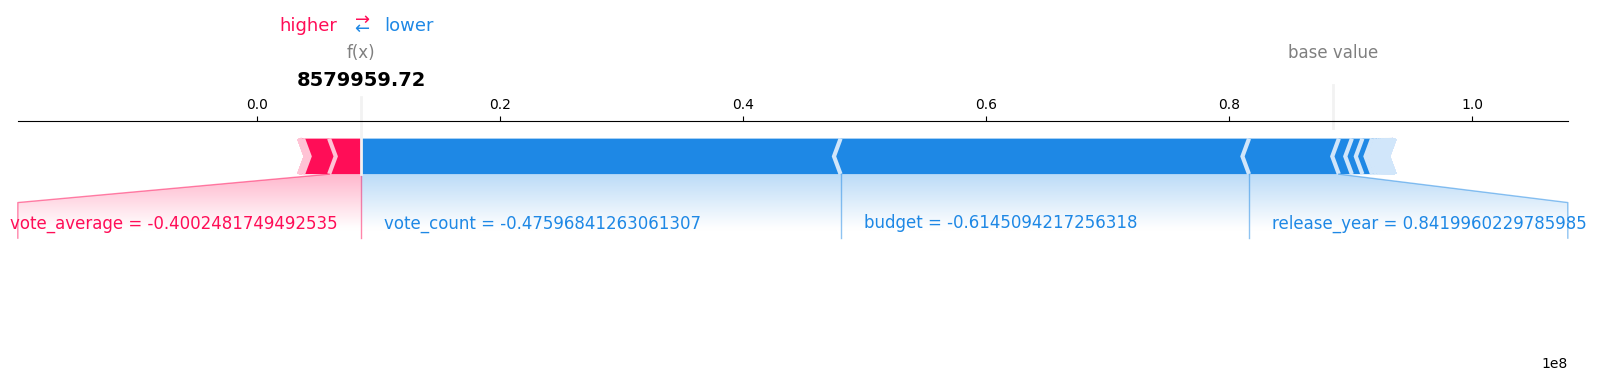

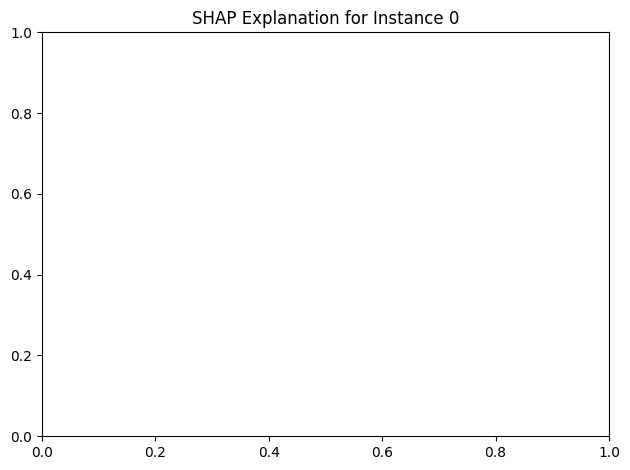

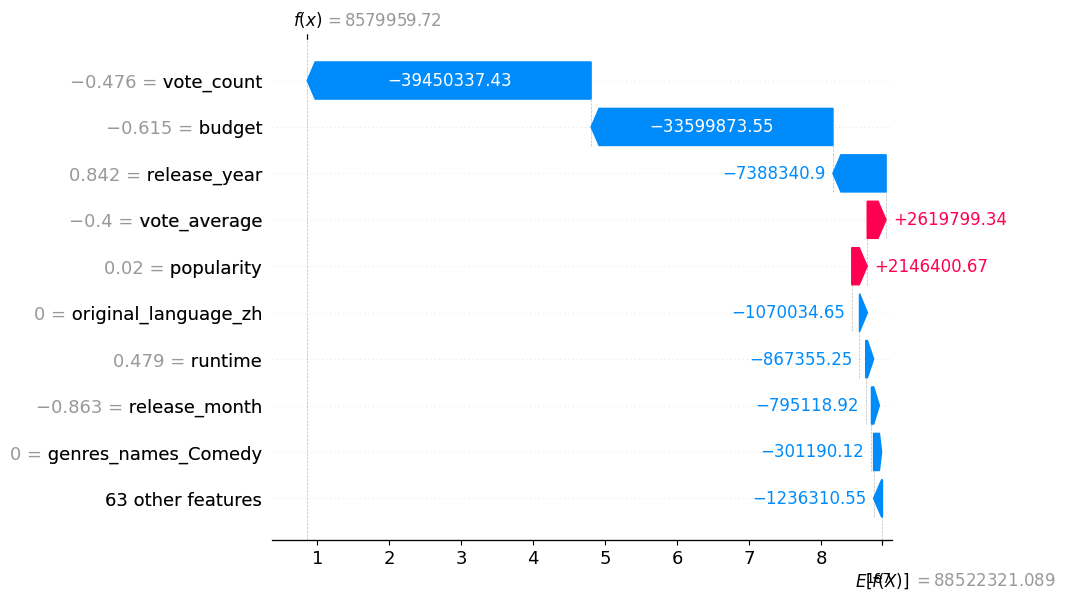

<Figure size 640x480 with 0 Axes>

In [15]:
import shap

# Configurar SHAP para evitar erros de memória
shap.initjs()  # Inicializar JS para visualizações

# Amostrar dados para tornar o SHAP viável
sample_size = min(100, len(X_test_dense))
sample_indices = np.random.choice(len(X_test_dense), sample_size, replace=False)
X_sample = X_test_dense[sample_indices]
y_sample = y_test.iloc[sample_indices]

# Criar explainer SHAP
explainer = shap.TreeExplainer(rf_model)

# Calcular valores SHAP para a amostra
shap_values = explainer.shap_values(X_sample)

# 1. Gráfico de importância global
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names, plot_type="bar")
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# 2. Gráfico de resumo SHAP
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names)
plt.title("SHAP Value Distribution")
plt.tight_layout()
plt.show()

# 3. Gráfico de dependência para a feature mais importante
most_important_feature = perm_importance_df.iloc[0]['Feature']
feature_index = all_feature_names.index(most_important_feature)

plt.figure(figsize=(10, 6))
shap.dependence_plot(
    feature_index, 
    shap_values, 
    X_sample, 
    feature_names=all_feature_names,
    interaction_index=None
)
plt.title(f"SHAP Dependence Plot for {most_important_feature}")
plt.tight_layout()
plt.show()

# 4. Explicação individual para uma instância
instance_idx = 0  # Primeira instância na amostra

# Force plot
shap.force_plot(
    explainer.expected_value, 
    shap_values[instance_idx], 
    X_sample[instance_idx],
    feature_names=all_feature_names,
    matplotlib=True
)
plt.title(f"SHAP Explanation for Instance {instance_idx}")
plt.tight_layout()
plt.show()

# Waterfall plot
shap.plots.waterfall(shap.Explanation(
    values=shap_values[instance_idx],
    base_values=explainer.expected_value,
    data=X_sample[instance_idx],
    feature_names=all_feature_names
))
plt.tight_layout()
plt.show()